In [ ]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import DataLoader, Dataset,Subset
from torchvision import transforms , datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import timm
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print(os.listdir('/content/drive/My Drive/Colab Notebooks/Aerial_Landscapes'))

Mounted at /content/drive
['Airport', 'Agriculture', 'City', 'Beach', 'Desert', 'Forest', 'Highway', 'Grassland', 'Lake', 'Mountain', 'Port', 'Parking', 'Residential', 'Railway', 'River']


In [ ]:
img_path ='/content/drive/My Drive/Colab Notebooks/Aerial_Landscapes'

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


dataset_path = img_path


dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

print("labels:", dataset.classes)
print("number:", len(dataset))

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())
torch.cuda.empty_cache()



labels: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
number: 12000
Tesla T4


In [ ]:

indices = np.arange(len(dataset))

y = np.array(dataset.targets)


train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=y)
print("train data:", len(train_idx))
print("test data:", len(test_idx))


train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(dataset.classes)
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
model = model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}")

    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    print("=== Classification Report ===")
    print(classification_report(
        y_true,
        y_pred,
        target_names=dataset.classes,
        digits=4
    ))

train data: 9600
test data: 2400


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1: 100%|██████████| 300/300 [01:01<00:00,  4.84it/s]

Epoch 1/20 - Loss: 0.5439


Test Accuracy: 0.9083
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9470    0.8938    0.9196       160
     Airport     0.8314    0.8938    0.8614       160
       Beach     0.9662    0.8938    0.9286       160
        City     0.9709    0.6250    0.7605       160
      Desert     0.9036    0.9375    0.9202       160
      Forest     0.9536    0.9000    0.9260       160
   Grassland     0.8743    0.9563    0.9134       160
     Highway     0.8820    0.9812    0.9290       160
        Lake     0.9387    0.9563    0.9474       160
    Mountain     0.8909    0.9187    0.9046       160
     Parking     0.9684    0.9563    0.9623       160
        Port     0.9812    0.9812    0.9812       160
     Railway     0.8933    0.8375    0.8645       160
 Residential     0.7794    0.9938    0.8736       160
       River     0.9231    0.9000    0.9114       160

    accuracy                         0.9083      2400
   macro avg     0.9136    0

Epoch 2:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2: 100%|██████████| 300/300 [01:02<00:00,  4.81it/s]

Epoch 2/20 - Loss: 0.2081


Test Accuracy: 0.9496
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9618    0.9437    0.9527       160
     Airport     0.9673    0.9250    0.9457       160
       Beach     0.9249    1.0000    0.9610       160
        City     0.9294    0.9875    0.9576       160
      Desert     0.9390    0.9625    0.9506       160
      Forest     0.9390    0.9625    0.9506       160
   Grassland     0.9235    0.9812    0.9515       160
     Highway     0.9133    0.9875    0.9489       160
        Lake     0.9854    0.8438    0.9091       160
    Mountain     0.9112    0.9625    0.9362       160
     Parking     0.9873    0.9750    0.9811       160
        Port     0.9937    0.9812    0.9874       160
     Railway     0.9669    0.9125    0.9389       160
 Residential     1.0000    0.9437    0.9711       160
       River     0.9211    0.8750    0.8974       160

    accuracy                         0.9496      2400
   macro avg     0.9509    0

Epoch 3:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 3: 100%|██████████| 300/300 [01:04<00:00,  4.68it/s]

Epoch 3/20 - Loss: 0.1487


Test Accuracy: 0.9563
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9023    0.9812    0.9401       160
     Airport     0.9739    0.9313    0.9521       160
       Beach     0.9632    0.9812    0.9721       160
        City     0.9868    0.9375    0.9615       160
      Desert     0.9684    0.9563    0.9623       160
      Forest     0.8820    0.9812    0.9290       160
   Grassland     0.9852    0.8313    0.9017       160
     Highway     0.9689    0.9750    0.9720       160
        Lake     0.9286    0.9750    0.9512       160
    Mountain     0.9613    0.9313    0.9460       160
     Parking     0.9876    0.9938    0.9907       160
        Port     0.9875    0.9875    0.9875       160
     Railway     0.9448    0.9625    0.9536       160
 Residential     0.9875    0.9875    0.9875       160
       River     0.9371    0.9313    0.9342       160

    accuracy                         0.9563      2400
   macro avg     0.9577    0

Epoch 4:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4: 100%|██████████| 300/300 [01:02<00:00,  4.80it/s]

Epoch 4/20 - Loss: 0.1323


Test Accuracy: 0.9504
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9461    0.9875    0.9664       160
     Airport     0.8851    0.9625    0.9222       160
       Beach     0.9871    0.9563    0.9714       160
        City     0.8771    0.9812    0.9263       160
      Desert     0.9679    0.9437    0.9557       160
      Forest     0.9244    0.9938    0.9578       160
   Grassland     0.9671    0.9187    0.9423       160
     Highway     0.9805    0.9437    0.9618       160
        Lake     0.9675    0.9313    0.9490       160
    Mountain     0.9205    0.8688    0.8939       160
     Parking     1.0000    0.9750    0.9873       160
        Port     0.9518    0.9875    0.9693       160
     Railway     0.9744    0.9500    0.9620       160
 Residential     0.9812    0.9812    0.9812       160
       River     0.9459    0.8750    0.9091       160

    accuracy                         0.9504      2400
   macro avg     0.9518    0

Epoch 5:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5: 100%|██████████| 300/300 [01:02<00:00,  4.82it/s]

Epoch 5/20 - Loss: 0.1279


Test Accuracy: 0.9604
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9578    0.9938    0.9755       160
     Airport     0.9506    0.9625    0.9565       160
       Beach     0.9515    0.9812    0.9662       160
        City     0.9871    0.9563    0.9714       160
      Desert     0.8634    0.9875    0.9213       160
      Forest     0.9748    0.9688    0.9718       160
   Grassland     0.9623    0.9563    0.9592       160
     Highway     0.9873    0.9688    0.9779       160
        Lake     0.9563    0.9563    0.9563       160
    Mountain     0.9926    0.8438    0.9122       160
     Parking     1.0000    0.9688    0.9841       160
        Port     0.9682    0.9500    0.9590       160
     Railway     0.9682    0.9500    0.9590       160
 Residential     0.9695    0.9938    0.9815       160
       River     0.9394    0.9688    0.9538       160

    accuracy                         0.9604      2400
   macro avg     0.9619    0

Epoch 6:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 6: 100%|██████████| 300/300 [01:01<00:00,  4.84it/s]

Epoch 6/20 - Loss: 0.1091


Test Accuracy: 0.9542
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.8966    0.9750    0.9341       160
     Airport     0.9503    0.9563    0.9533       160
       Beach     0.9191    0.9938    0.9550       160
        City     0.9745    0.9563    0.9653       160
      Desert     0.8771    0.9812    0.9263       160
      Forest     0.9874    0.9812    0.9843       160
   Grassland     0.9673    0.9250    0.9457       160
     Highway     0.9752    0.9812    0.9782       160
        Lake     0.9789    0.8688    0.9205       160
    Mountain     0.9686    0.9625    0.9655       160
     Parking     0.9755    0.9938    0.9845       160
        Port     0.9874    0.9812    0.9843       160
     Railway     0.9860    0.8812    0.9307       160
 Residential     0.9874    0.9812    0.9843       160
       River     0.9051    0.8938    0.8994       160

    accuracy                         0.9542      2400
   macro avg     0.9558    0

Epoch 7:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7: 100%|██████████| 300/300 [01:03<00:00,  4.70it/s]

Epoch 7/20 - Loss: 0.0952


Test Accuracy: 0.9504
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9521    0.9938    0.9725       160
     Airport     0.9398    0.9750    0.9571       160
       Beach     0.9627    0.9688    0.9657       160
        City     0.9868    0.9313    0.9582       160
      Desert     0.8634    0.9875    0.9213       160
      Forest     0.9752    0.9812    0.9782       160
   Grassland     0.9578    0.9938    0.9755       160
     Highway     0.9620    0.9500    0.9560       160
        Lake     0.9773    0.8063    0.8836       160
    Mountain     0.9712    0.8438    0.9030       160
     Parking     0.9627    0.9688    0.9657       160
        Port     0.9937    0.9812    0.9874       160
     Railway     0.9673    0.9250    0.9457       160
 Residential     0.9581    1.0000    0.9786       160
       River     0.8588    0.9500    0.9021       160

    accuracy                         0.9504      2400
   macro avg     0.9526    0

Epoch 8:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 8: 100%|██████████| 300/300 [01:03<00:00,  4.76it/s]

Epoch 8/20 - Loss: 0.0933


Test Accuracy: 0.9325
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.8882    0.9437    0.9152       160
     Airport     0.9357    0.8187    0.8733       160
       Beach     0.9448    0.9625    0.9536       160
        City     0.9684    0.9563    0.9623       160
      Desert     0.9686    0.9625    0.9655       160
      Forest     0.9667    0.9062    0.9355       160
   Grassland     0.9448    0.9625    0.9536       160
     Highway     0.9430    0.9313    0.9371       160
        Lake     0.8093    0.9812    0.8870       160
    Mountain     0.9613    0.9313    0.9460       160
     Parking     0.9874    0.9812    0.9843       160
        Port     0.9860    0.8812    0.9307       160
     Railway     0.8475    0.9375    0.8902       160
 Residential     0.9752    0.9812    0.9782       160
       River     0.9067    0.8500    0.8774       160

    accuracy                         0.9325      2400
   macro avg     0.9356    0

Epoch 9:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 9: 100%|██████████| 300/300 [01:02<00:00,  4.81it/s]

Epoch 9/20 - Loss: 0.0827


Test Accuracy: 0.9583
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9515    0.9812    0.9662       160
     Airport     0.9684    0.9563    0.9623       160
       Beach     0.9632    0.9812    0.9721       160
        City     0.9321    0.9437    0.9379       160
      Desert     0.9625    0.9625    0.9625       160
      Forest     0.9573    0.9812    0.9691       160
   Grassland     0.9464    0.9938    0.9695       160
     Highway     1.0000    0.9625    0.9809       160
        Lake     0.9565    0.9625    0.9595       160
    Mountain     0.9658    0.8812    0.9216       160
     Parking     1.0000    0.9500    0.9744       160
        Port     0.9630    0.9750    0.9689       160
     Railway     0.9560    0.9500    0.9530       160
 Residential     0.9191    0.9938    0.9550       160
       River     0.9412    0.9000    0.9201       160

    accuracy                         0.9583      2400
   macro avg     0.9589    0

Epoch 10:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10: 100%|██████████| 300/300 [01:02<00:00,  4.81it/s]

Epoch 10/20 - Loss: 0.0862


Test Accuracy: 0.9579
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9286    0.9750    0.9512       160
     Airport     0.8941    0.9500    0.9212       160
       Beach     0.9812    0.9812    0.9812       160
        City     0.9568    0.9688    0.9627       160
      Desert     0.9931    0.9000    0.9443       160
      Forest     0.9345    0.9812    0.9573       160
   Grassland     0.9509    0.9688    0.9598       160
     Highway     0.9747    0.9625    0.9686       160
        Lake     0.9521    0.9938    0.9725       160
    Mountain     0.9023    0.9812    0.9401       160
     Parking     0.9753    0.9875    0.9814       160
        Port     0.9876    0.9938    0.9907       160
     Railway     0.9679    0.9437    0.9557       160
 Residential     0.9937    0.9812    0.9874       160
       River     1.0000    0.8000    0.8889       160

    accuracy                         0.9579      2400
   macro avg     0.9595    0

Epoch 11:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 11: 100%|██████████| 300/300 [01:04<00:00,  4.66it/s]

Epoch 11/20 - Loss: 0.0812


Test Accuracy: 0.9546
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9686    0.9625    0.9655       160
     Airport     1.0000    0.8438    0.9153       160
       Beach     0.9752    0.9812    0.9782       160
        City     0.9337    0.9688    0.9509       160
      Desert     0.9349    0.9875    0.9605       160
      Forest     0.9565    0.9625    0.9595       160
   Grassland     0.9697    1.0000    0.9846       160
     Highway     0.9739    0.9313    0.9521       160
        Lake     0.9739    0.9313    0.9521       160
    Mountain     0.9862    0.8938    0.9377       160
     Parking     0.9873    0.9688    0.9779       160
        Port     1.0000    0.9500    0.9744       160
     Railway     0.8325    0.9938    0.9060       160
 Residential     0.9634    0.9875    0.9753       160
       River     0.9053    0.9563    0.9301       160

    accuracy                         0.9546      2400
   macro avg     0.9574    0

Epoch 12:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12: 100%|██████████| 300/300 [01:02<00:00,  4.81it/s]

Epoch 12/20 - Loss: 0.0952


Test Accuracy: 0.9587
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9521    0.9938    0.9725       160
     Airport     0.9693    0.9875    0.9783       160
       Beach     0.9461    0.9875    0.9664       160
        City     0.9695    0.9938    0.9815       160
      Desert     0.9464    0.9938    0.9695       160
      Forest     0.9695    0.7937    0.8729       160
   Grassland     0.7980    0.9875    0.8827       160
     Highway     0.9937    0.9812    0.9874       160
        Lake     0.9565    0.9625    0.9595       160
    Mountain     0.9737    0.9250    0.9487       160
     Parking     0.9815    0.9938    0.9876       160
        Port     1.0000    0.9563    0.9776       160
     Railway     0.9869    0.9437    0.9649       160
 Residential     0.9936    0.9750    0.9842       160
       River     0.9932    0.9062    0.9477       160

    accuracy                         0.9587      2400
   macro avg     0.9620    0

Epoch 13:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13: 100%|██████████| 300/300 [01:01<00:00,  4.85it/s]

Epoch 13/20 - Loss: 0.0616


Test Accuracy: 0.9537
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9294    0.9875    0.9576       160
     Airport     0.9451    0.9688    0.9568       160
       Beach     0.9697    1.0000    0.9846       160
        City     0.9745    0.9563    0.9653       160
      Desert     0.9747    0.9625    0.9686       160
      Forest     0.8876    0.9875    0.9349       160
   Grassland     0.9805    0.9437    0.9618       160
     Highway     0.9803    0.9313    0.9551       160
        Lake     0.9799    0.9125    0.9450       160
    Mountain     0.9630    0.8125    0.8814       160
     Parking     0.9873    0.9688    0.9779       160
        Port     1.0000    0.9500    0.9744       160
     Railway     0.8785    0.9938    0.9326       160
 Residential     0.9815    0.9938    0.9876       160
       River     0.9036    0.9375    0.9202       160

    accuracy                         0.9537      2400
   macro avg     0.9557    0

Epoch 14:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 14: 100%|██████████| 300/300 [01:01<00:00,  4.88it/s]

Epoch 14/20 - Loss: 0.0802


Test Accuracy: 0.9604
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9268    0.9500    0.9383       160
     Airport     0.9487    0.9250    0.9367       160
       Beach     0.9639    1.0000    0.9816       160
        City     0.9186    0.9875    0.9518       160
      Desert     0.9630    0.9750    0.9689       160
      Forest     0.9398    0.9750    0.9571       160
   Grassland     0.9691    0.9812    0.9752       160
     Highway     0.9935    0.9563    0.9745       160
        Lake     0.9341    0.9750    0.9541       160
    Mountain     0.9854    0.8438    0.9091       160
     Parking     0.9876    0.9938    0.9907       160
        Port     0.9816    1.0000    0.9907       160
     Railway     0.9742    0.9437    0.9587       160
 Residential     0.9752    0.9812    0.9782       160
       River     0.9545    0.9187    0.9363       160

    accuracy                         0.9604      2400
   macro avg     0.9611    0

Epoch 15:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 15: 100%|██████████| 300/300 [01:03<00:00,  4.69it/s]

Epoch 15/20 - Loss: 0.0676


Test Accuracy: 0.9525
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9568    0.9688    0.9627       160
     Airport     0.9933    0.9250    0.9579       160
       Beach     0.9752    0.9812    0.9782       160
        City     0.9691    0.9812    0.9752       160
      Desert     0.9848    0.8125    0.8904       160
      Forest     0.9800    0.9187    0.9484       160
   Grassland     0.7960    1.0000    0.8864       160
     Highway     0.9801    0.9250    0.9518       160
        Lake     0.9613    0.9313    0.9460       160
    Mountain     0.9286    0.9750    0.9512       160
     Parking     1.0000    0.9875    0.9937       160
        Port     0.9405    0.9875    0.9634       160
     Railway     0.9349    0.9875    0.9605       160
 Residential     0.9873    0.9750    0.9811       160
       River     0.9551    0.9313    0.9430       160

    accuracy                         0.9525      2400
   macro avg     0.9562    0

Epoch 16:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 16: 100%|██████████| 300/300 [01:03<00:00,  4.74it/s]

Epoch 16/20 - Loss: 0.0895


Test Accuracy: 0.9587
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9176    0.9750    0.9455       160
     Airport     0.9790    0.8750    0.9241       160
       Beach     0.9753    0.9875    0.9814       160
        City     0.9745    0.9563    0.9653       160
      Desert     0.9451    0.9688    0.9568       160
      Forest     0.9932    0.9187    0.9545       160
   Grassland     0.9521    0.9938    0.9725       160
     Highway     0.9748    0.9688    0.9718       160
        Lake     0.9682    0.9500    0.9590       160
    Mountain     0.9255    0.9313    0.9283       160
     Parking     0.9636    0.9938    0.9785       160
        Port     0.9935    0.9563    0.9745       160
     Railway     0.9444    0.9563    0.9503       160
 Residential     0.9876    0.9938    0.9907       160
       River     0.9000    0.9563    0.9273       160

    accuracy                         0.9587      2400
   macro avg     0.9596    0

Epoch 17:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 17: 100%|██████████| 300/300 [01:02<00:00,  4.83it/s]

Epoch 17/20 - Loss: 0.0556


Test Accuracy: 0.9621
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9630    0.9750    0.9689       160
     Airport     0.9684    0.9563    0.9623       160
       Beach     0.9815    0.9938    0.9876       160
        City     0.9932    0.9125    0.9511       160
      Desert     0.9451    0.9688    0.9568       160
      Forest     0.9742    0.9437    0.9587       160
   Grassland     0.9040    1.0000    0.9496       160
     Highway     0.9632    0.9812    0.9721       160
        Lake     0.9636    0.9938    0.9785       160
    Mountain     0.9217    0.9563    0.9387       160
     Parking     0.9632    0.9812    0.9721       160
        Port     0.9938    0.9938    0.9938       160
     Railway     0.9277    0.9625    0.9448       160
 Residential     0.9938    0.9938    0.9938       160
       River     0.9924    0.8187    0.8973       160

    accuracy                         0.9621      2400
   macro avg     0.9632    0

Epoch 18:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 18: 100%|██████████| 300/300 [01:02<00:00,  4.82it/s]

Epoch 18/20 - Loss: 0.0648


Test Accuracy: 0.9608
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9684    0.9563    0.9623       160
     Airport     0.9870    0.9500    0.9682       160
       Beach     0.9695    0.9938    0.9815       160
        City     0.9752    0.9812    0.9782       160
      Desert     0.9848    0.8125    0.8904       160
      Forest     0.9627    0.9688    0.9657       160
   Grassland     0.9565    0.9625    0.9595       160
     Highway     0.9518    0.9875    0.9693       160
        Lake     0.9620    0.9500    0.9560       160
    Mountain     0.8307    0.9812    0.8997       160
     Parking     0.9755    0.9938    0.9845       160
        Port     0.9938    0.9938    0.9938       160
     Railway     0.9679    0.9437    0.9557       160
 Residential     1.0000    0.9812    0.9905       160
       River     0.9563    0.9563    0.9563       160

    accuracy                         0.9608      2400
   macro avg     0.9628    0

Epoch 19:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 19: 100%|██████████| 300/300 [01:03<00:00,  4.72it/s]

Epoch 19/20 - Loss: 0.0677


Test Accuracy: 0.9762
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9455    0.9750    0.9600       160
     Airport     0.9935    0.9500    0.9712       160
       Beach     0.9815    0.9938    0.9876       160
        City     0.9750    0.9750    0.9750       160
      Desert     0.9810    0.9688    0.9748       160
      Forest     0.9814    0.9875    0.9844       160
   Grassland     0.9812    0.9812    0.9812       160
     Highway     0.9875    0.9875    0.9875       160
        Lake     0.9745    0.9563    0.9653       160
    Mountain     0.9509    0.9688    0.9598       160
     Parking     0.9877    1.0000    0.9938       160
        Port     0.9937    0.9812    0.9874       160
     Railway     0.9512    0.9750    0.9630       160
 Residential     0.9937    0.9812    0.9874       160
       River     0.9686    0.9625    0.9655       160

    accuracy                         0.9762      2400
   macro avg     0.9764    0

Epoch 20:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 20: 100%|██████████| 300/300 [01:02<00:00,  4.80it/s]

Epoch 20/20 - Loss: 0.0457


Test Accuracy: 0.9625
=== Classification Report ===
              precision    recall  f1-score   support

 Agriculture     0.9029    0.9875    0.9433       160
     Airport     0.9737    0.9250    0.9487       160
       Beach     0.9811    0.9750    0.9781       160
        City     0.9408    0.9938    0.9666       160
      Desert     0.9509    0.9688    0.9598       160
      Forest     0.9560    0.9500    0.9530       160
   Grassland     0.9632    0.9812    0.9721       160
     Highway     0.9689    0.9750    0.9720       160
        Lake     0.9620    0.9500    0.9560       160
    Mountain     0.9329    0.9563    0.9444       160
     Parking     0.9937    0.9812    0.9874       160
        Port     1.0000    0.9563    0.9776       160
     Railway     0.9935    0.9625    0.9778       160
 Residential     0.9576    0.9875    0.9723       160
       River     0.9726    0.8875    0.9281       160

    accuracy                         0.9625      2400
   macro avg     0.9633    0

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


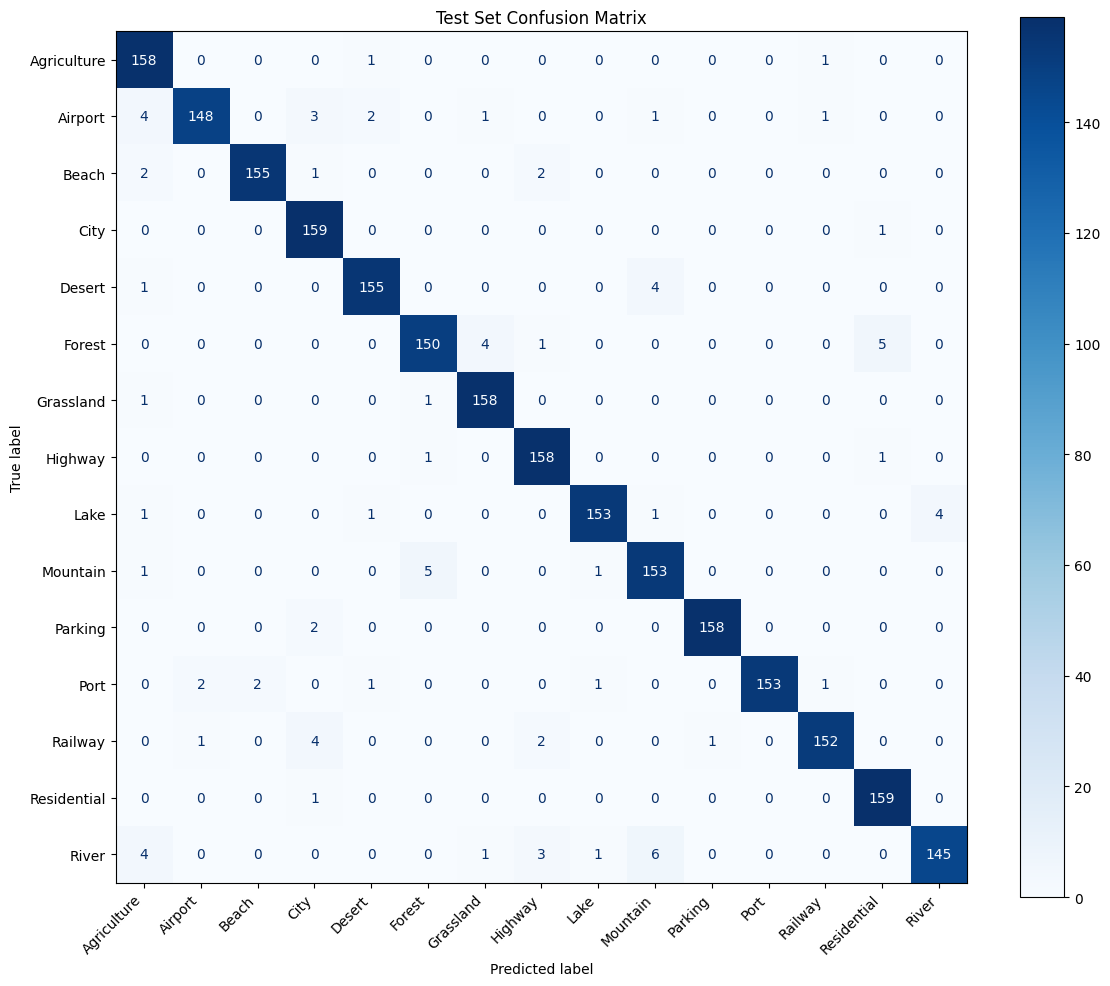

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(12, 10))


disp = ConfusionMatrixDisplay(cm, display_labels=dataset.classes)
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')


plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title("Test Set Confusion Matrix")
plt.tight_layout()

plt.show()